In [1]:
import pandas as pd
import pylab as plt
import requests
import os
import urllib
import base64
import io
import numpy as np
import locale

Download Data from JHU repository and convert to dataframes

In [2]:
github_repo = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/'
time_series_dir = 'csse_covid_19_data/csse_covid_19_time_series/'
def get_time_series(data_description):
    full_filename = f'time_series_19-covid-{data_description}.csv'
    base_uri = urllib.parse.urljoin(github_repo, time_series_dir)
    uri = urllib.parse.urljoin(base_uri, full_filename)

    response = requests.get(uri)
    if response.status_code == requests.codes.ok:
        return response.text

    print(uri, 'Returned error code:', req.status_code)

def parse_csv_string(csv_string):
    buffer = io.StringIO(csv_string)
    return pd.read_csv(buffer)

def get_dataframe(data_description):
    return parse_csv_string(get_time_series(data_description))

confirmed = get_dataframe('Confirmed')
recovered = get_dataframe('Recovered')
deaths = get_dataframe('Deaths')

Compute the latest regional statistics, based on the downloaded data:
    * Fraction Resolved: What fraction of the confirmed cases have either recovered or died?
    * Deaths Per Recovery: How many people have died for each person recovered?
    * Deaths Per Confirmed: How many people have died for each confirmed case?

In [3]:
latest_stats = confirmed.iloc[:,:4]
latest_stats['Confirmed'] = confirmed.iloc[:,-1]
latest_stats['Recovered'] = recovered.iloc[:,-1]
latest_stats['Deaths'] = deaths.iloc[:,-1]
latest_stats['Fraction Resolved'] = ((latest_stats['Recovered'] + latest_stats['Deaths'])/
                                     latest_stats['Confirmed'])
latest_stats['Deaths Per Recovery'] = ((latest_stats['Deaths'])/
                                         latest_stats['Recovered'])
latest_stats['Deaths Per Confirmed'] = ((latest_stats['Deaths'])/
                                         latest_stats['Confirmed'])

# Set up functions to plot progress
We want to plot Confirmed and Recovered cases over time for a given region. 

We will plot deaths on a separate axis, since it is a much smaller number.

In [4]:
def make_plot_title(index):
    province = confirmed.iloc[index]['Province/State']
    country = confirmed.iloc[index]['Country/Region']

    if isinstance(province, float):
        province = ''

    return f'{province} {country}'

def plot_progress(index, logy=False):
    
    ax = confirmed.iloc[index, 4:].plot(use_index=False,
                                        label='Confirmed',
                                       logy=logy)
    recovered.iloc[index, 4:].plot(use_index=False,
                                   label='Recovered',
                                   logy=logy)
    plt.title(make_plot_title(index))
    plt.xlabel('Days')
    plt.ylabel('Confirmed/Recovered')
    ax2 = ax.twinx()
    ax2.set_ylabel('Deaths')
    deaths.iloc[index, 4:].plot(use_index=False,
                                ax=ax2,
                                color='black',
                                label='Deaths',
                                logy=logy)

    ax.legend()
    ax2.legend(loc='lower right')
    
    plt.show()

#  Progress over Time in top 20 Regions 

For the regions with the 20 highest confirmed cases, plot the progress over time.

Deaths and Recovery, typically lags behind confirmed cases. We would expect this, since with a few exceptions, diagnoses occurs prior to recovery or death. 

For some regions, we see a nice flattening of the confirmed and recovered cases, as the infection has been slowed or stopped due to non-pharmaceutical interventions (social distancing). Because of the virus incubation period, we would expect the change in the cases to lag policy changes.

For other regions, the curves have not shown any sign of stopping. In some regions with recent outbreaks, there has not been enough time for a significant number of people to recover.


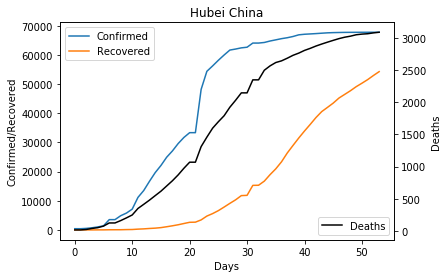

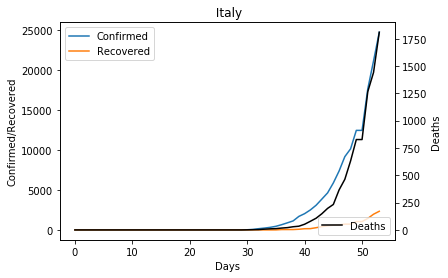

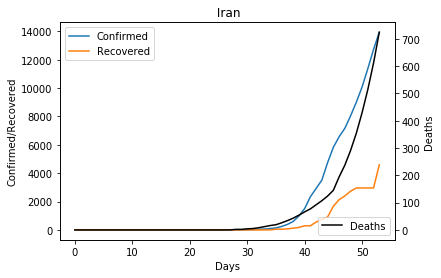

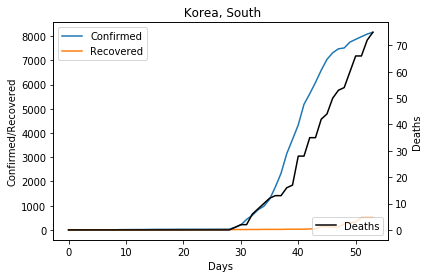

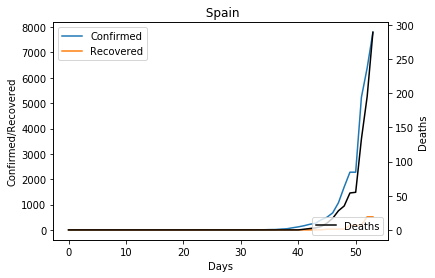

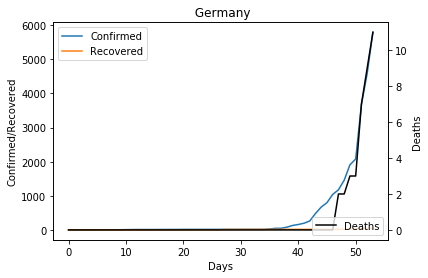

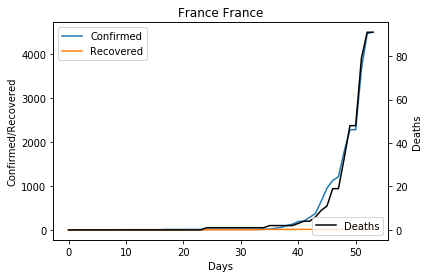

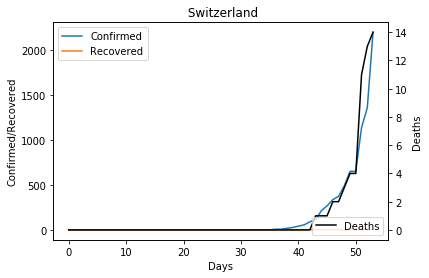

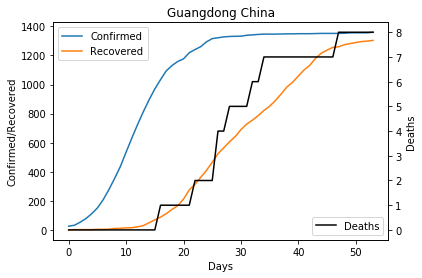

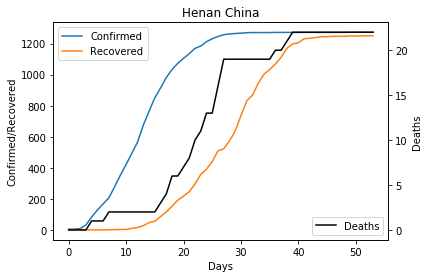

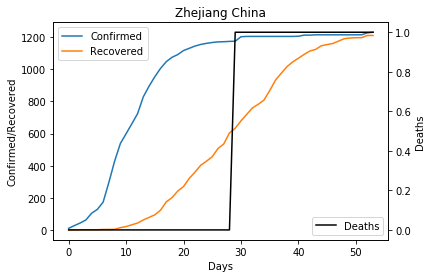

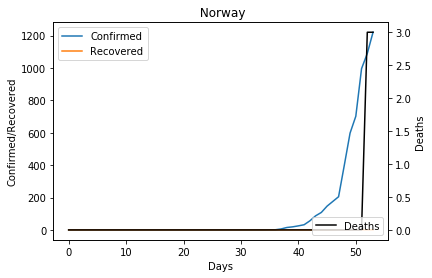

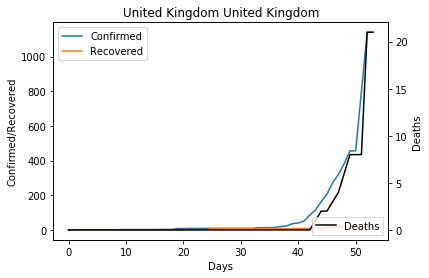

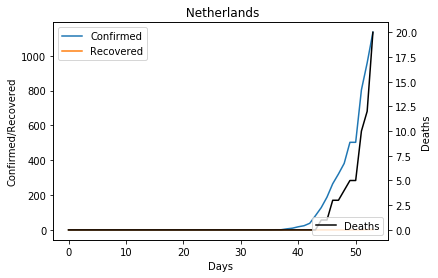

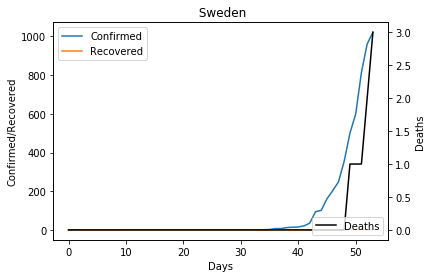

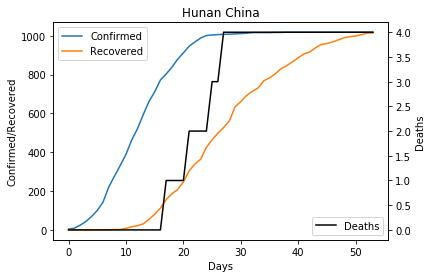

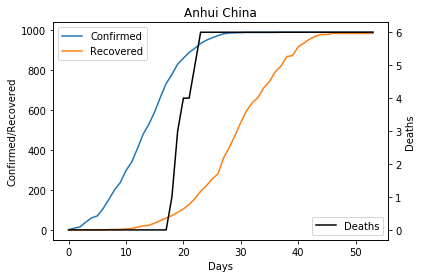

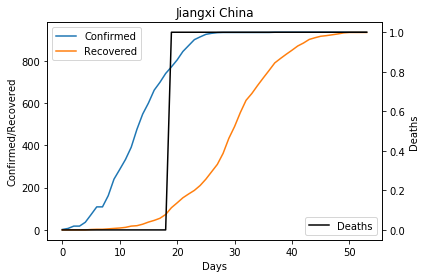

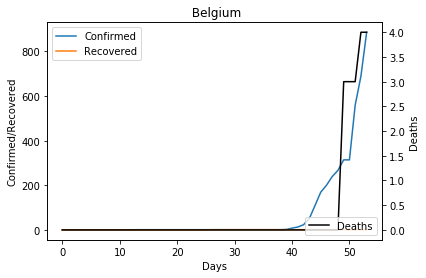

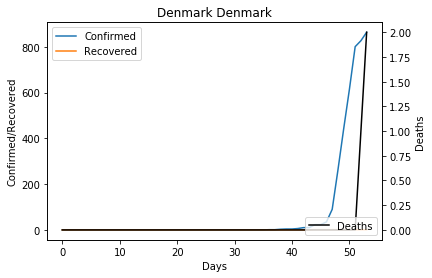

In [5]:
number_to_plot = 20
logy = False
for i in latest_stats.nlargest(number_to_plot, 'Confirmed').index:
    plot_progress(i, logy=logy)

16


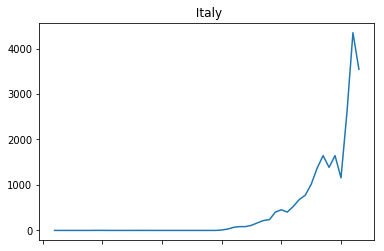

156


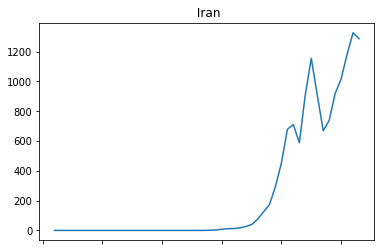

157


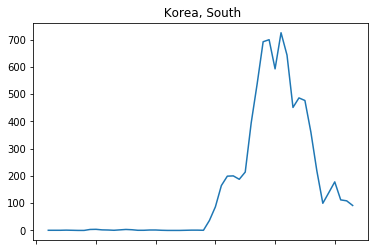

18


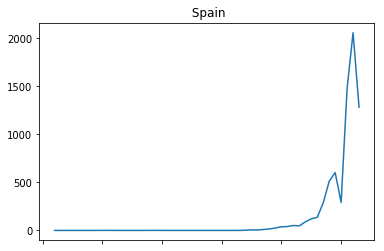

11


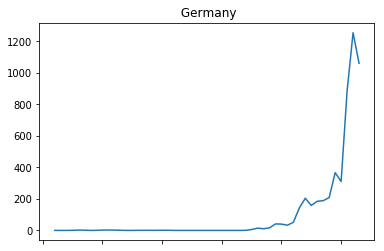

158


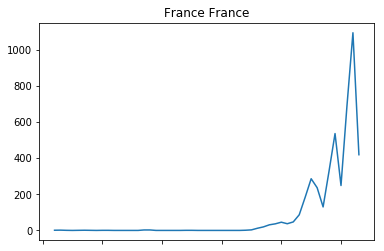

31


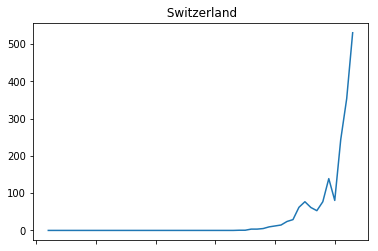

39


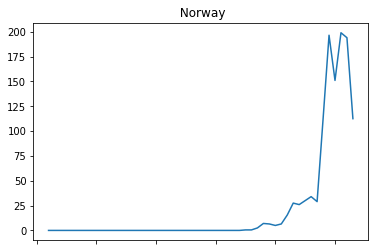

405


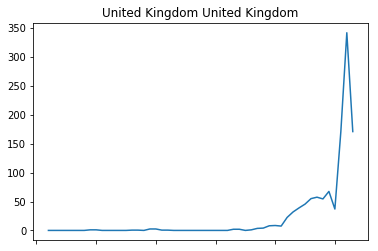

42


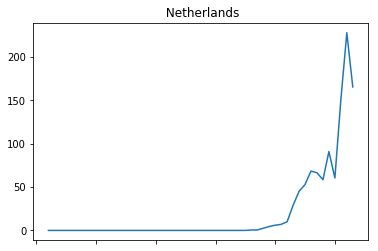

17


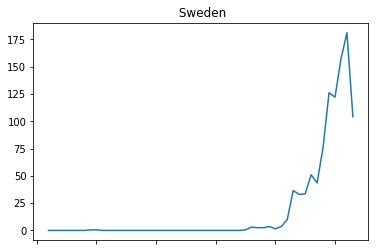

20


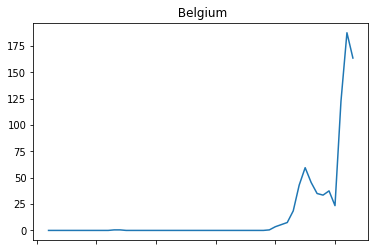

171


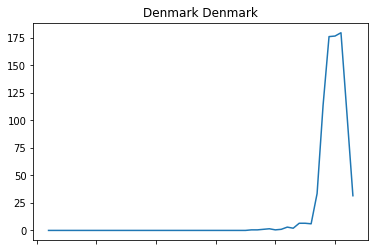

32


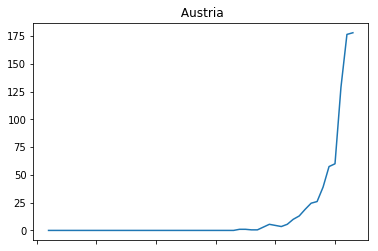

1


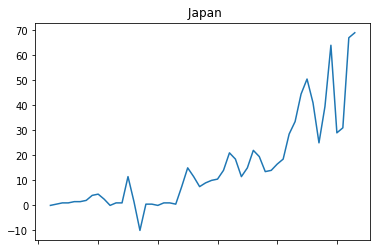

100


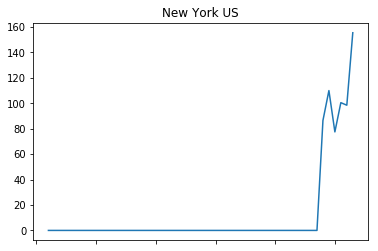

166


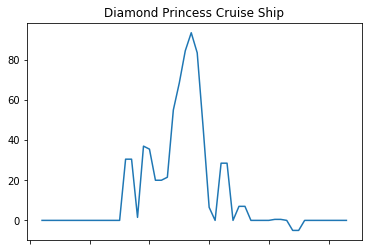

99


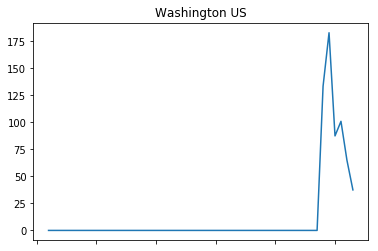

4


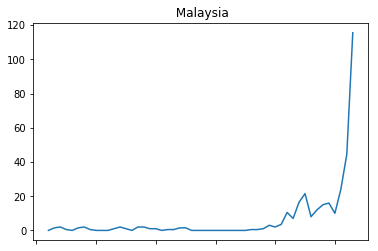

101


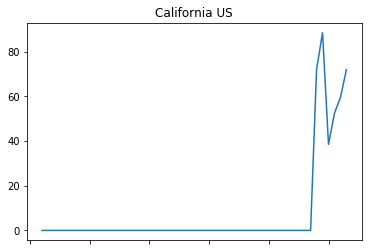

In [6]:
non_china = latest_stats[~latest_stats['Country/Region'].str.contains('China')]
period=2
for i in non_china.nlargest(number_to_plot, 'Confirmed').index:
    (confirmed.iloc[i,4:].diff(periods=period)/period).plot()
    print(i)
    plt.title(make_plot_title(i))
    plt.show()

# Plot Progress in Washington State
Note: JHU switched from aggregating by county to aggregating the state on March 10th

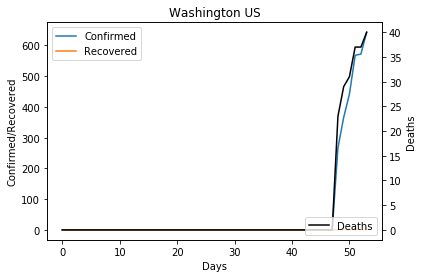

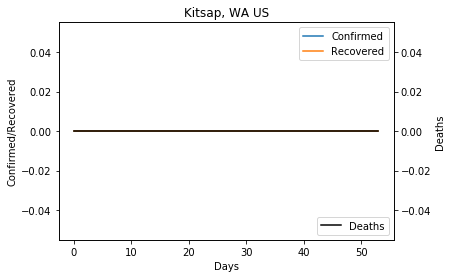

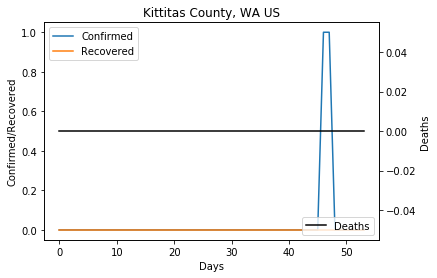

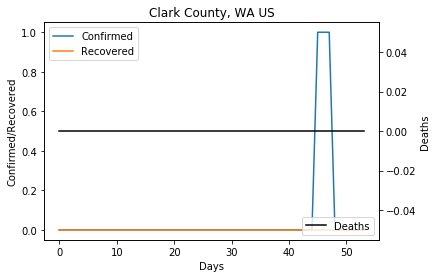

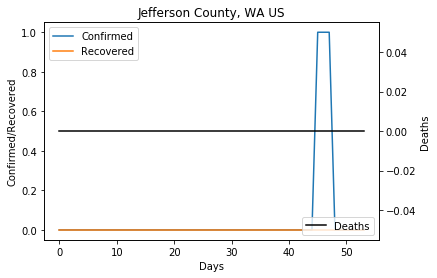

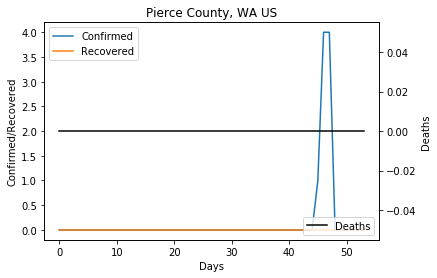

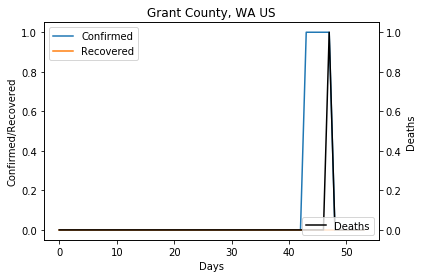

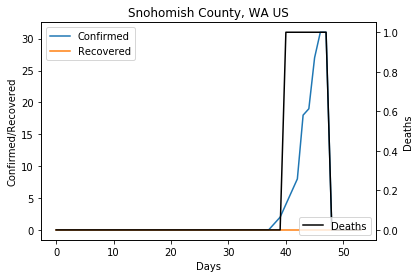

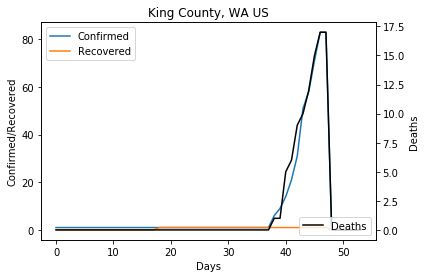

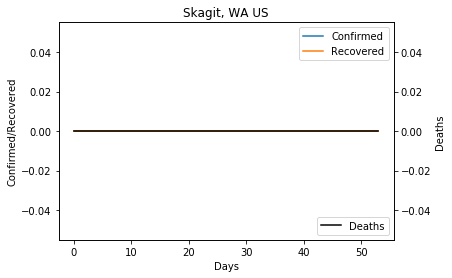

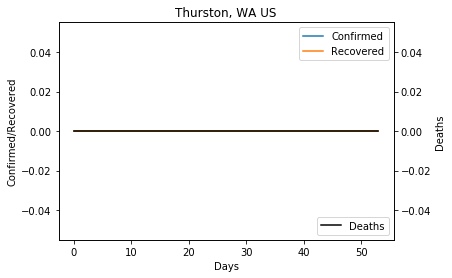

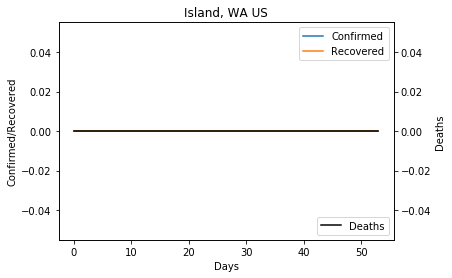

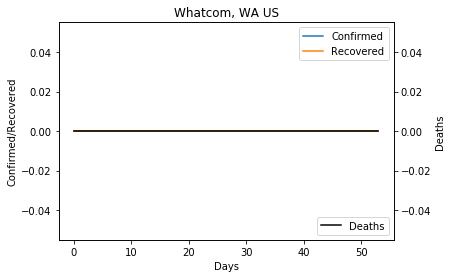

In [7]:
# Plot progress in Washington State for new data
for i, val in confirmed['Province/State'].str.match('Washington$').items():
    if isinstance(val, bool) and val:
        plot_progress(i)
# Plot progress by county for older data
for i, val in confirmed['Province/State'].str.contains('WA').items():
    if isinstance(val, bool) and val:
        plot_progress(i)


# Estimate of Death Rate

Death rate is hard to estimate due to a number of uncertainty factors:
    * The number of confirmed cases may represent only a small fraction of total cases. While there is no
    authoritative estimate. Estimates in the press vary from 0.1% to 10%. This fraction probably varies highly
    from region to region, based on testing policies.
    * The death rate may not include all deaths due to COVID-19. Some deaths may have been attributed to flu or
    other causes, or simply not reported by authorities.
    * Death and recovery lag onset of symptoms by several days to weeks

References/Reources:
* https://www.medrxiv.org/content/medrxiv/early/2020/02/25/2020.02.11.20022186.full.pdf
* https://www.sciencealert.com/new-study-estimates-75-000-people-in-wuhan-infected-with-coronavirus

Now to try to a simple estimate. We will analyze regions with more than 100 confirmed cases. To try to control for recovery and deaths lagging confirmation, we will consider the infection to be "controlled" in a region if the fraction of confirmed cases resolved (death + recovery) is more than 90%.

We will compute the mean and median over all region and plot the histogram.

The histogram has some dramatic variation, with death rates ranging from 0 to 3.5%. Some of this variation may be due to variations in testing policy/availablility, patient population (age and health demographics), and access to health care. 

Since the fraction of cases confirmed is so unknown, we will try to estimate the death rate as a function the fraction confirmed.

Number of controlled regions: 22
Raw Median Death Rate 0.81%
Raw Mean Death Rate 1.02%


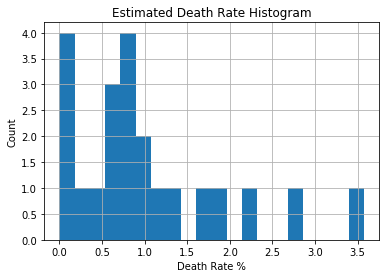

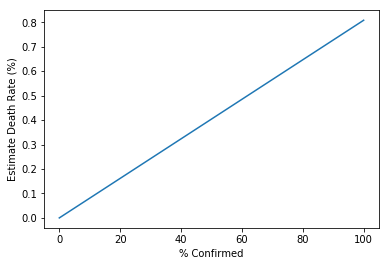

In [8]:
controlled = (latest_stats['Fraction Resolved'] > 0.9) & (latest_stats['Confirmed'] > 100)
death_rate_percent_estimate = latest_stats[controlled]['Deaths Per Confirmed'] * 100
print('Number of controlled regions:', len(death_rate_percent_estimate))
print(f'Raw Median Death Rate {death_rate_percent_estimate.median():.2f}%')
print(f'Raw Mean Death Rate {death_rate_percent_estimate.mean():.2f}%')
death_rate_percent_estimate.hist(bins=20)
plt.title('Estimated Death Rate Histogram')
plt.xlabel('Death Rate %')
plt.ylabel('Count')
plt.show()

fraction_confirmed = np.linspace(0,1,20)
plt.plot(fraction_confirmed*100, death_rate_percent_estimate.median()*fraction_confirmed)
plt.xlabel('% Confirmed')
plt.ylabel('Estimate Death Rate (%)')
plt.show()

# Pandemic implications in the US
If a large fraction of the US were to become infected, what would the impact be? We have some control over the outcome of the virus. By slowing the spread of the virus, we can reduce the total number of infections. We can reduce the death rate by avoiding overwhelming our healthcare resources and protect vulnerable populations.

In a pessimistic scenerio, the virus is allowed to grow unchecked and rapidly achieve 50-70% of the population infected. Hospitals would be overwhelmed and we would expect a higher deathrate. For this scenerio we will set the death rate based on the maximum of the regions in the previous section.

In a more optimistic epidemic scenerio, we place social distancing controls to limit the the spread of the virus to 20% of the population. At the same time, the infections come later and more gradually, allowing out health care system to provide better outcomes. In this scenerio, we will use the death rate based on the median over the regions in the previous section. 


The CDC [estimates](https://www.cdc.gov/flu/about/burden/index.html) the influenza is responsible for 12,000-64,00 

In [9]:
us_population = 327e+6
fraction_confirmed=0.1

def compute_deaths(infection_ratio, fraction_confirmed, death_rate):
    num_deaths = us_population * infection_ratio * fraction_confirmed * death_rate
    locale.setlocale(locale.LC_ALL, 'en_US')
    formatted = locale.format_string('%d', num_deaths, grouping=True)
    
    return formatted

optimistic_scenerio = compute_deaths(infection_ratio=0.1,
                         fraction_confirmed=fraction_confirmed,
                         death_rate=death_rate_percent_estimate.median()/100)
pessimistic_scenerio = compute_deaths(infection_ratio=0.6,
                         fraction_confirmed=fraction_confirmed,
                         death_rate=death_rate_percent_estimate.max()/100)

print(f"Estimates ranged from {optimistic_scenerio} to {pessimistic_scenerio} deaths.")

Estimates ranged from 26,426 to 700,714 deaths.


# Estimation of R0

Using the methodology defined here [https://www.medrxiv.org/content/medrxiv/early/2020/02/25/2020.02.11.20022186.full.pdf], we attempt to estimate the replication factor. Defining:

$C(t) =$ Number of confirmed

$R(t) =$ Number of recovered

$D(t) =$ Number of deaths

$I(T) =$ Number of infected $= C(t)-R(t)-D(t)$
    

$R_0 =$ ${\Delta C(t)+\Delta R(t)+\Delta D(t)}\over{\Delta R(t) +\Delta D(t) }$

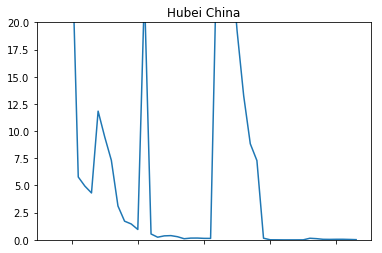

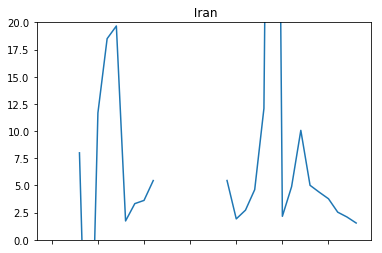

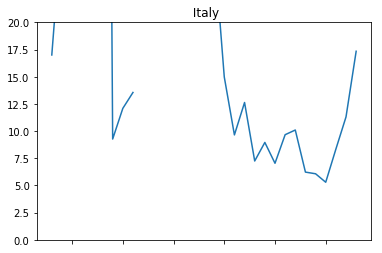

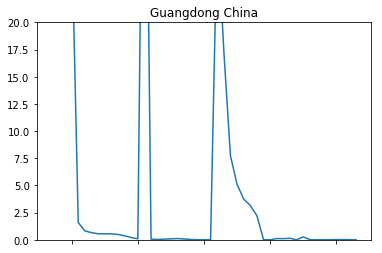

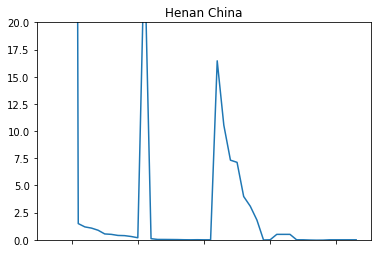

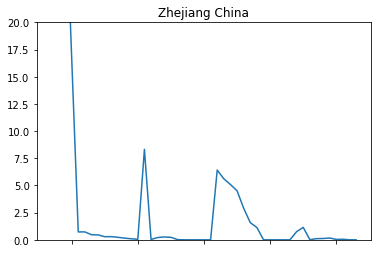

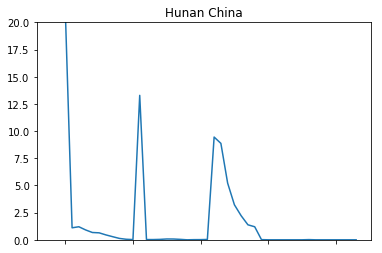

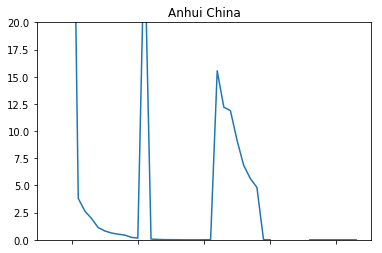

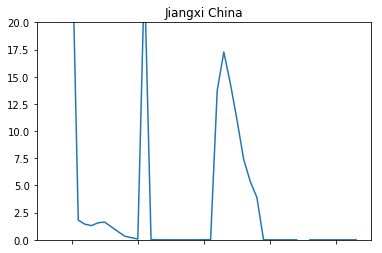

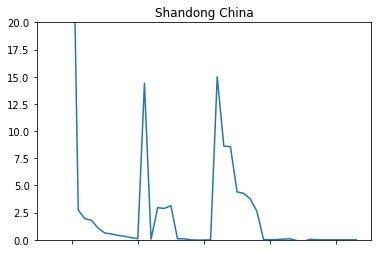

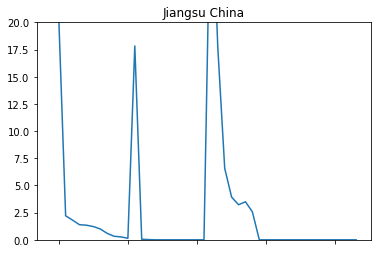

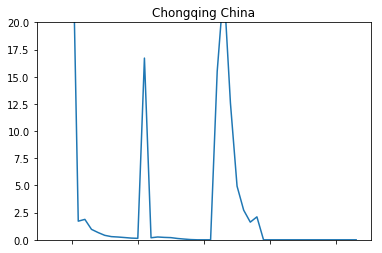

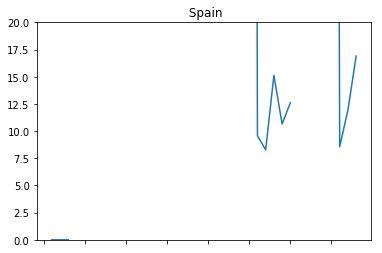

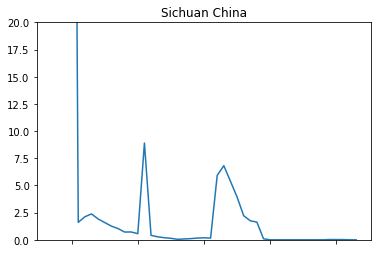

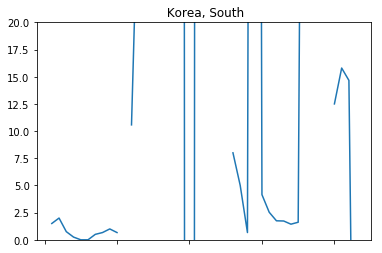

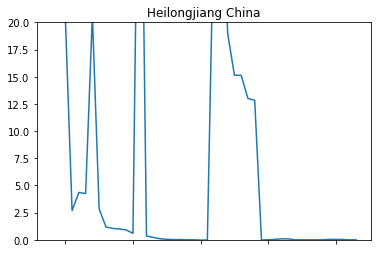

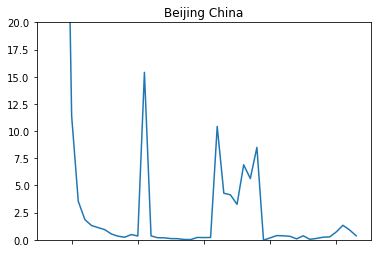

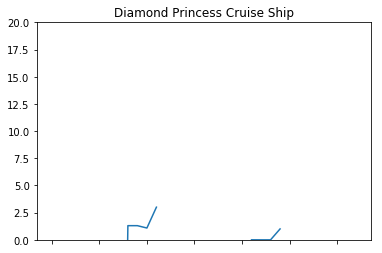

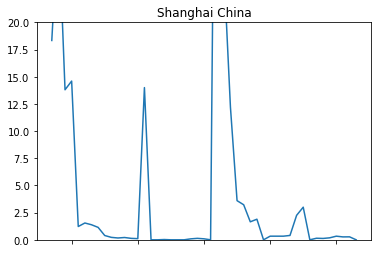

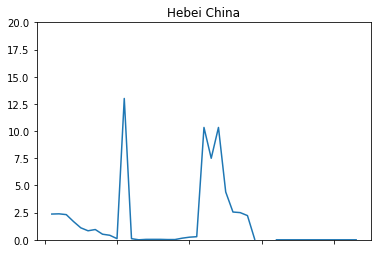

In [10]:
window=3
nplots=20
infected = confirmed.iloc[:,4:]-recovered.iloc[:,4:]-deaths.iloc[:,4:]
delta_infected=infected.iloc[:,4:].diff(axis=1, periods=window)
delta_recovered=recovered.iloc[:,4:].diff(axis=1, periods=window)
delta_deaths=deaths.iloc[:,4:].diff(axis=1, periods=window).diff(axis=1)
reproduction = (delta_infected+delta_recovered+delta_deaths)/(
    delta_recovered+delta_deaths)
for i in latest_stats.nlargest(nplots, 'Recovered').index:
    reproduction.iloc[i].plot()
    plt.ylim(0, 20)
    plt.title(make_plot_title(i))
    plt.show()